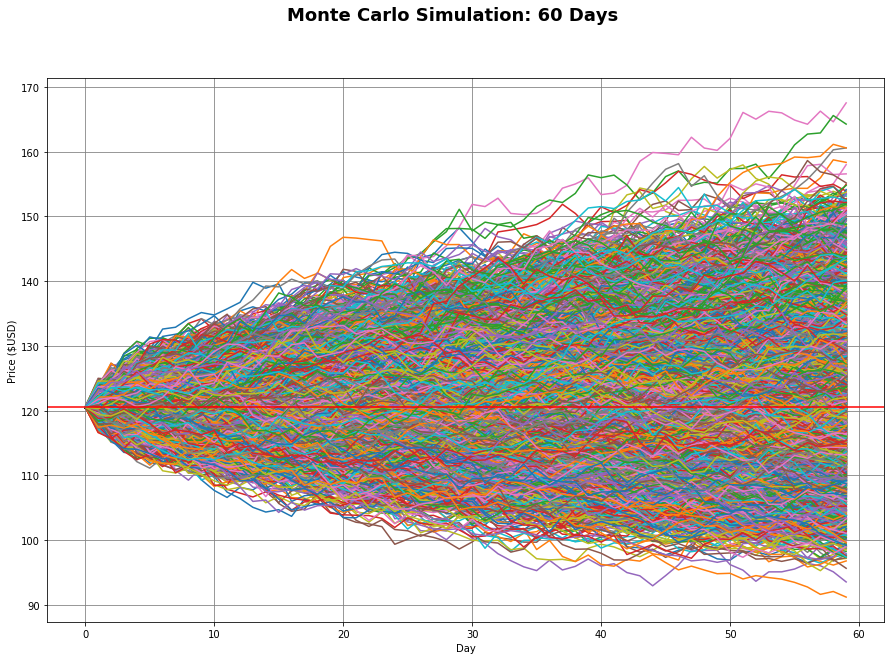

120.54000091552734
CALL


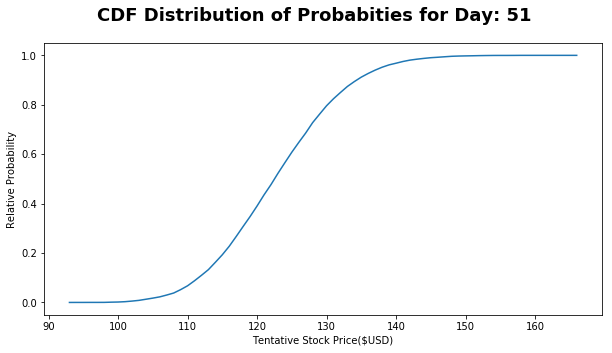

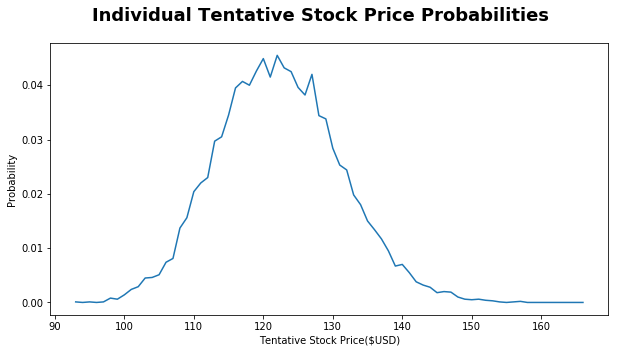

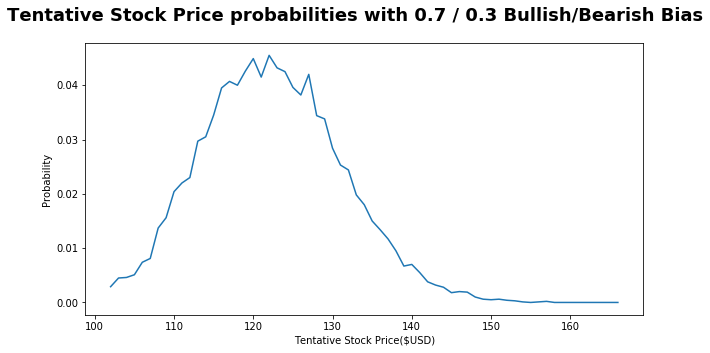

               Recommended Strategy
symbol                             
PG_101819C60              Long Call
PG_101819C65              Long Call
PG_101819C70              Long Call
PG_101819C75              Long Call
PG_101819C80              Long Call
PG_101819C85              Long Call
PG_101819C90              Long Call
PG_101819C92.5            Long Call
PG_101819C95              Long Call
PG_101819C97.5            Long Call
PG_101819C100             Long Call
PG_101819C105             Long Call
PG_101819C110             Long Call
PG_101819C115             Long Call
PG_101819C120             Long Call
PG_101819C125             Long Call
PG_101819C130             Long Call
PG_101819C135             Long Call
PG_101819C140             Long Call
PG_101819C145             Long Call
PG_101819C150            Naked Call
PG_101819C155            Naked Call
PG_101819C160            Naked Call


In [43]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
import requests
import json
%matplotlib inline


# The following function does a Monte Carlo Simulation of GBM to help predict stock price by 
# returning a graph that plots the probability of a stock reaching a particular price on a certain day.
# Input parameters are the stock you want to look at, the max number of days in the future you want a prediction for,
# and the number of Monte Carlo simulations you want to perform
def monte_carlo(symbol, num_days, iterations):
    ticker = symbol 
    data = pd.DataFrame()
    data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2009-1-1')['Adj Close']

    log_returns = np.log(1 + data.pct_change())
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()

    t_intervals = num_days
    iterations = iterations
    daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))

    S0 = data.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0

    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]

    fig = plt.figure(figsize=(15,10))
    title = "Monte Carlo Simulation: " + str(t_intervals) + " Days"
    plt.plot(price_list)
    fig.suptitle(title,fontsize=18, fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Price ($USD)')
    plt.grid(True,color='grey')
    plt.axhline(y=data.iloc[-1].values[0], color='r', linestyle='-')
    plt.show()
    print(data.iloc[-1].values[0])
    return price_list


# This is a utility function to help us see the probability of a stock reaching a single
# price on a single given day. Input is the results of the MC simulation, price you want to inspect,
# and what day in the future you want a prediction on prices for
def find_prob(price_list, input_price, day):
    prob_list = price_list[day, :] #Price list is 60x100, we are inspecting the prices on the 60th day for prob of a certain price on the 60th day
    count = 0
    for item in prob_list:
        if item > input_price:
            count = count + 1
    return count/len(prob_list)
    
# Following code makes relevant tokens necessary to conduct TD ameritrade activities on behalf of my account
# Note refresh token is valid for 90 days. It is used to generate auth token which is only valid for 30 mins
def get_auth_token():
    refresh_token = 'sXtUVLkSa8gbLhTjgVRPJDkx0J2khZOwk6uN+q0KlnrLoNuz6Fnm893VKp76zqml0GWZ73K1Oler9JJYMNFxziNe58G+SQ5zLgqLdA3EXVO3FXIPSR74glOqGddJ2hKH9tXL1oWft5WCE6ZUpq/zjPhsJSBPi8yGx2RnSABUc7FMqTeYOUcBztjjCUl4/jgk2F076hyrrDCSBX/yakGHA09jHcbQZOOl8vyrxu/UfrjEgfxNi4YuEMKz23pcHd2L77dJRBMTugYYnFzRpHMHdGukWedlgOO4/RgQgsZ3nAKEFrSYUS9XrugrREalD2Ufo+onBbkr+N1EP+BEyinufwOkrwsebgw/5FQKB9fJzbNw/79nXeS0ZG4OHlHA3shPP6JbJOUeh2Fwev/yuhrE6sGwfcdvftzn8vFTe52KGJrBe5RapEb+n+DxkJm100MQuG4LYrgoVi/JHHvlrueqQYnI53tYFD84wI4dnFH19sX584k0XZTqmBn4M2JDQqiO4SRIMAOVtkogDmlhOHMo1xDZVUG1aDRSdnoXe3EbnfnYI8h/PfIRyBUeVolmaUDfR5KUQ7etO7BMYlfC4w0hKhbcl1HayMZLi9lgtCPqW2cjoonhrywNt+TjlwG1zwxdfBL+T2YJmyb4jGYKe3r+/LfVV/Mo73zzodDajQtkCLjbtCcGPs8SrETi73eslhHuVxhUs73PBJBhwQAnwFXy1WsgNHANr3M733dxb/kJqlSkJTTN416SeuMuu69pM8j/T7AW1+Ly/d4OVjiIhpp5ZlU9U9YrSVdSQtD9A3Tt/VHI3jIHNn0yDMyweZlwfzzHKXDVEemNXPWXu3iGj/VZqujZ3RL0ZnpNHbQDf8PX+LjkY+0e7HteljkhgZlg4X0Q5F4YySluQCE=212FD3x19z9sWBHDJACbC00B75E'
    auth_params = {'grant_type':'refresh_token', 'refresh_token':refresh_token, 'client_id':'TESTAUTH122@AMER.OAUTHAP'}
    auth_api_url = 'https://api.tdameritrade.com/v1/oauth2/token'
    return "Bearer "+ requests.post(auth_api_url, data=auth_params).json()['access_token']


# Following code will get the option chain data using the authorized token
# Parameters: call_or_put: 'CALL'/'PUT'; symbol: string with stock symbol from passed in stock list
def get_raw_option_data(call_or_put, symbol):
    url = 'https://api.tdameritrade.com/v1/marketdata/chains'
    strike_count = '50000000' #need to figure out how to get ALL or just use an arbitraliy huge num
    strategy = 'SINGLE'
    authorization_header = {'Authorization': get_auth_token()}
    if call_or_put == 'CALL':
        pay = {'symbol':symbol,'strikeCount':strike_count, 'strategy':strategy, 'contractType': 'CALL'}
    elif call_or_put == 'PUT':
        pay = {'symbol':symbol,'strikeCount':strike_count, 'strategy':strategy, 'contractType': 'PUT'}
    return [requests.get(url, params = pay, headers = authorization_header).json()['callExpDateMap'], requests.get(url, params = pay, headers = authorization_header).json()['underlyingPrice']]

       
# This function uses the results of the Monte Carlo Simulation. On a selected day in the future, it finds the
# probability of the stock reaching various prices. This produces a roughly bell curve like distribution. 
# This distribution is them transformed to a CDF for a relative ranking of probabilities which is returned from the function.
# Inputs are the results from MC simulation and the selected day in the future that you are interested in
def preprocess_probs(price_list, selected_day):
    prob_list = price_list[selected_day, :]
    min_price = min(prob_list)
    max_price = max(prob_list)
    prob_dic = {}
    for price in range(int(min_price), int(max_price+1)):
        count = 0
        for item in prob_list:
            if price > item:
                count = count + 1
        prob_dic[price] = count/len(prob_list)
    x, y = zip(*prob_dic.items())
    fig = plt.figure(figsize=(10,5))
    title = "CDF Distribution of Probabities for Day: " + str(selected_day)
    plt.plot(x, y)
    fig.suptitle(title,fontsize=18, fontweight='bold')
    plt.xlabel('Tentative Stock Price($USD)')
    plt.ylabel('Relative Probability')
    plt.show()
    return (dict(zip(x, tuple(y))), max_price, min_price)


# This function takes rhe CDF results from preprocess probs and creates discrete probabilities for the stock
# reaching a particular price
def create_bell_curve(monte_carlo_results, selected_day):
    results = preprocess_probs(monte_carlo_results, selected_day)
    prob_dic = results[0]
    max_price = results[1]
    min_price = results[2]
    prob_bin_unfiltered = {}
    for sp in prob_dic:
        try: 
            prob_bin_unfiltered[sp] = prob_dic[sp+1] - prob_dic[sp]
        except Exception as e:
            prob_bin_unfiltered[sp] = prob_bin_unfiltered[sp-1]
    x, y = zip(*prob_bin_unfiltered.items())
    fig = plt.figure(figsize=(10,5))
    title = "Individual Tentative Stock Price Probabilities"
    plt.plot(x, y)
    fig.suptitle(title,fontsize=18, fontweight='bold')
    plt.xlabel('Tentative Stock Price($USD)')
    plt.ylabel('Probability')
    plt.show()
    return dict(zip(x, tuple(y)))


# This function biases the original bell curve based on how bullish/bearish we expect the market to be on a future date
# by shifting the curve.
# Inputs are the MC results, a selected day in the future that we are interested in, our bullish/bearish assumption and
# current stock price
def create_biased_curve(monte_carlo_results, selected_day, bullish_ratio, bearish_ratio, stock_price):
    unbiased_curve = create_bell_curve(monte_carlo_results, selected_day)
    if bullish_ratio == bearish_ratio:
        return unbiased_curve
    else:
        lower_half = {}
        upper_half = {}
        for item in unbiased_curve:
            if item < stock_price:
                lower_half[item] = unbiased_curve[item]
            else:
                upper_half[item] = unbiased_curve[item]
        if bullish_ratio > bearish_ratio:
            while((len(upper_half)/len(lower_half)) < (bullish_ratio/bearish_ratio)):
                key_to_remove = list(lower_half.keys())[0]
                lower_half.pop(key_to_remove)
        elif bearish_ratio > bullish_ratio:
            while((len(lower_half)/len(upper_half)) < (bearish_ratio/bullish_ratio)):
                keys = upper_half.keys()
                key_to_remove = list(upper_half.keys())[len(keys)-1]
                upper_half.pop(key_to_remove)
        final = {**lower_half, **upper_half}
        x, y = zip(*final.items())
        fig = plt.figure(figsize=(10,5))
        title = "Tentative Stock Price probabilities with " + str(bullish_ratio) + " / " + str(bearish_ratio) + " Bullish/Bearish Bias"
        plt.plot(x, y)
        fig.suptitle(title,fontsize=18, fontweight='bold')
        plt.xlabel('Tentative Stock Price($USD)')
        plt.ylabel('Probability')
        plt.show()
        return dict(zip(x, tuple(y)))
    
    


# This funciton create a smaller bin of probabilities from the larger CDF Probability distribution. 
# This smaller bin is created by inputs of the MC simulation, a selected day in the future, current stock price,
# and how bullish or bearish we expect the market to be. Based on how Bullish/Bearish we expect, this function 
# returns a skewered version(a smaller bin) of the probabilities to use for future P/L calculations.
# This is effectively the same as the biased curve function. 
def create_prob_bins(monte_carlo_results, selected_day, bullish_frac, bearish_frac, stock_price):
    results = preprocess_probs(monte_carlo_results, selected_day)
    prob_dic = results[0]
    max_price = results[1]
    min_price = results[2]
    prob_counter = 0
    upper = stock_price
    lower = stock_price
    prob_bin = {}
    breaking_flag = 0
    while prob_counter < 1:
        if breaking_flag == 1:
            break
        bull_count = 0
        bear_count = 0
        if bullish_frac > bearish_frac:
            while bull_count < (bullish_frac*10) and prob_counter < 1 and breaking_flag != 1:
                max_prob = max(prob_dic[upper+1],prob_dic[upper])
                min_prob = min(prob_dic[upper+1],prob_dic[upper])
                prob_bin[upper+1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                upper = upper + 1
                if upper+1 > max_price:
                    breaking_flag = 1
                bull_count = bull_count + 1
            while bear_count < (bearish_frac*10) and prob_counter < 1:
                max_prob = max(prob_dic[lower],prob_dic[lower - 1])
                min_prob = min(prob_dic[lower],prob_dic[lower - 1])
                prob_bin[lower-1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                lower = lower - 1
                bear_count = bear_count + 1
        else:
            while bear_count < (bearish_frac*10) and prob_counter < 1 and breaking_flag != 1:
                max_prob = max(prob_dic[lower],prob_dic[lower - 1])
                min_prob = min(prob_dic[lower],prob_dic[lower - 1])
                prob_bin[lower-1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                lower = lower - 1
                if lower-1 < min_price:
                    breaking_flag = 1
                bear_count = bear_count + 1
            while bull_count < (bullish_frac*10) and prob_counter < 1:
                max_prob = max(prob_dic[upper+1],prob_dic[upper])
                min_prob = min(prob_dic[upper+1],prob_dic[upper])
                prob_bin[upper+1] = max_prob - min_prob
                prob_counter = prob_counter + max_prob - min_prob
                upper = upper + 1
                bull_count = bull_count + 1
    x, y = zip(*sorted(prob_bin.items()))
    fig = plt.figure(figsize=(15,10))
    title = "Selected Probability for a " + str(bullish_frac) + " / " + str(bearish_frac) + " Bullish/Bearish Split"
    plt.plot(x, y)
    fig.suptitle(title,fontsize=18, fontweight='bold')
    plt.xlabel('Tentative Stock Price($USD)')
    plt.ylabel('Relative Probability')
    plt.show()
    return (dict(zip(x,y)))
    #return prob_bin
        

# This function uses the previously created biased curve to compute P/L if we are using long call strategy        
def long_call_PL(strike_price, premium, prob_bin):
    lower_sum = 0
    middle_sum = 0
    upper_sum = 0
    for price in prob_bin:
        if price < strike_price:
            lower_sum  = lower_sum + (-1*premium*prob_bin[price])
        elif price > (strike_price+premium):
            upper_sum = upper_sum + (price - (strike_price+premium))*prob_bin[price]
        else:
            middle_sum = middle_sum + (price - strike_price)*prob_bin[price] #Already gonna be negative
    return lower_sum+middle_sum+upper_sum


# This function uses the previously created biased curve to compute P/L if we are using naked call strategy 
def naked_call_PL(strike_price, premium, prob_bin):
    lower_sum = 0
    middle_sum = 0
    upper_sum = 0
    for price in prob_bin:
        if price < strike_price:
            lower_sum  = lower_sum + (premium*prob_bin[price])
        elif price > (strike_price+premium):
            upper_sum = upper_sum + (price - (strike_price+premium))*prob_bin[price]*-1
        else:
            middle_sum = middle_sum + (price - strike_price)*prob_bin[price]*-1 #Need to flip to a pos.
    return lower_sum+middle_sum+upper_sum


# This function uses the previously created biased curve to compute P/L if we are using long put strategy 
def long_put_PL(strike_price, premium, prob_bin):
    lower_sum = 0
    middle_sum = 0
    upper_sum = 0
    for price in prob_bin:
        if price < (strike_price-premium):
            lower_sum  = lower_sum + (price - (strike_price - premium))*prob_bin[price]
        elif (price - strike_price) < premium:
            middle_sum = middle_sum + (price - strike_price)*prob_bin[price]*-1 #make negative a pos.
        else:
            upper_sum = upper_sum + (premium*prob_bin[price])
    return lower_sum+middle_sum+upper_sum


# This function uses the previously created biased curve to compute P/L if we are using short put strategy 
def short_put_PL(strike_price, premium, prob_bin):
    lower_sum = 0
    middle_sum = 0
    upper_sum = 0
    for price in prob_bin:
        if price < (strike_price-premium):
            lower_sum  = lower_sum + (price - (strike_price - premium))*prob_bin[price]*-1
        elif (price - strike_price) < premium:
            middle_sum = middle_sum + (price - strike_price)*prob_bin[price] #Already neg
        else:
            upper_sum = upper_sum + (-1*premium*prob_bin[price])
    return lower_sum+middle_sum+upper_sum
    
# Utility function to return best call strategy     
def best_call_strategy(strike_price, ask, bid, prob_bin):
    long_call = long_call_PL(strike_price, ask, prob_bin)
    naked_call = naked_call_PL(strike_price, bid, prob_bin)
    max_profit = max(long_call, naked_call)
    if max_profit == long_call:
        return "Long Call"
    elif max_profit == naked_call:
        return "Naked Call"
    
# Utility function to return best put strategy
def best_put_strategy(strike_price, ask, bid, prob_bin):
    long_put = long_put_PL(strike_price, ask, prob_bin)
    short_put = short_put_PL(strike_price, bid, prob_bin)
    max_profit = max(long_put, short_put)
    if max_profit == long_put:
        return "Long Put"
    elif max_profit == short_put:
        return "Short Put"
    
        
# This function gets all the raw option data and computes the best strategy for each option contract.
# Function takes as input stock symbol, the string "CALL" or "PUT" depending on what type of contract is desired,
# MC results, selected future day, bullish/bearish ratios and computes
# an instance of a biased curve to makes its decision on what strategy to use to compute P/L
# Requirements: selected future day must be selected s.t there are call options avaiable for that day
def assign_strategies(symbol, call_or_put, monte_carlo_results, selected_day, bullish_ratio, bearish_ratio):
    data = get_raw_option_data(call_or_put, symbol)
    agg_data = {}
    date_keys = []
    for (k,v) in data[0].items():
        date_keys.append([k,list(v.keys())])
        agg_data[k] = v
    print(agg_data[date_keys[0][0]][date_keys[0][1][0]][0]['putCall']) #This is an example of how we can access data. Can make less complicated if necessary using a different data structure but this should be good enough performace-wise
    target_list = []
    stock_price = data[1]
    #print(stock_price)
    prob_bin = create_biased_curve(monte_carlo_results, selected_day, bullish_ratio, bearish_ratio, round(stock_price))
    if call_or_put == "CALL":
        for i in range(0,len(date_keys)):
            for j in range(0, len(date_keys[i][1])):
                if agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'] == selected_day :
                    target = {'symbol': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['symbol'], 
                                   'Recommended Strategy': best_call_strategy(agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['bid'], prob_bin)}
                    target_list.append(target)
    if call_or_put == "PUT":
        for i in range(0,len(date_keys)):
            for j in range(0, len(date_keys[i][1])):
                if agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['daysToExpiration'] == selected_day :
                    target = {'symbol': agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['symbol'], 
                                   'Recommended Strategy': best_put_strategy(agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['strikePrice'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['ask'], agg_data[date_keys[i][0]][date_keys[i][1][j]][0]['bid'], prob_bin)}
                    target_list.append(target)
    df = pd.DataFrame(target_list)
    df = df.set_index('symbol', drop = True)
    return df
    
    
    
    
if __name__== "__main__":
    symbol = 'PG'
    monte_carlo_results = monte_carlo('PG', 60, 10000)    
    print(assign_strategies(symbol, "CALL", monte_carlo_results, 51, 0.7, 0.3))
    
    
    
    
    